In [153]:
import numpy as np
import torch
from torchvision.datasets import mnist
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as func
import torch.optim as optim
from torch import nn

In [154]:
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20
lr = 0.01
momentum = 0.5

In [155]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
train_dataset = mnist.MNIST('./data', train = True, transform = transform, download = True)
test_dataset = mnist.MNIST('./data', train = False, transform = transform)
train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle = False)

In [156]:
from matplotlib import pyplot as plt
%matplotlib inline

In [157]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

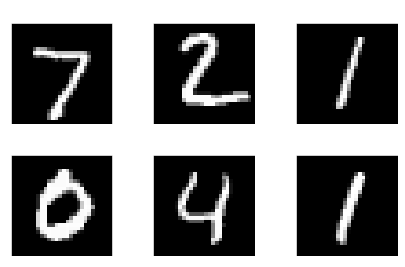

In [158]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap = 'gray', interpolation = 'none')
    plt.title('Ground Truth: {}'.format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [159]:
class Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
    def forward(self, x):
        x = func.relu(self.layer1(x))
        x = func.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [160]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(28 * 28, 300, 100, 10)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)

In [161]:
losses = []
acces = []
eval_losses = []
eval_acces = []

In [162]:
for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    if epoch % 5 == 0:
        optimizer.param_groups[0]['lr'] *= 0.1
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)

        out = model(img)
        loss = criterion(out, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))

    eval_loss = 0
    eval_acc = 0
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)

        eval_loss += loss.item()
        
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
    .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader), eval_loss / len(test_loader), eval_acc / len(test_loader)))

epoch: 0, Train Loss: 1.0072, Train Acc: 0.7946, Test Loss: 0.5429, Test Acc: 0.9024
epoch: 1, Train Loss: 0.4770, Train Acc: 0.9029, Test Loss: 0.3513, Test Acc: 0.9243
epoch: 2, Train Loss: 0.3447, Train Acc: 0.9215, Test Loss: 0.2734, Test Acc: 0.9394
epoch: 3, Train Loss: 0.2792, Train Acc: 0.9338, Test Loss: 0.2251, Test Acc: 0.9466
epoch: 4, Train Loss: 0.2388, Train Acc: 0.9418, Test Loss: 0.1986, Test Acc: 0.9526
epoch: 5, Train Loss: 0.2192, Train Acc: 0.9472, Test Loss: 0.1933, Test Acc: 0.9534
epoch: 6, Train Loss: 0.2161, Train Acc: 0.9472, Test Loss: 0.1904, Test Acc: 0.9544
epoch: 7, Train Loss: 0.2118, Train Acc: 0.9485, Test Loss: 0.1875, Test Acc: 0.9534
epoch: 8, Train Loss: 0.2100, Train Acc: 0.9496, Test Loss: 0.1877, Test Acc: 0.9541
epoch: 9, Train Loss: 0.2081, Train Acc: 0.9498, Test Loss: 0.1849, Test Acc: 0.9558
epoch: 10, Train Loss: 0.2056, Train Acc: 0.9504, Test Loss: 0.1847, Test Acc: 0.9553
epoch: 11, Train Loss: 0.2068, Train Acc: 0.9494, Test Loss: 0.1

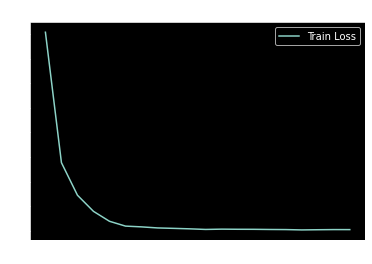

In [163]:
plt.title('trainloss')
plt.plot(np.arange(len(losses)), losses)
plt.legend(['Train Loss'], loc = 'upper right')